# Autoencoders for Anomaly Detection

## Introduction
Autoencoders are a type of neural network used to learn efficient representations of data, typically for dimensionality reduction or feature learning. They work by encoding the input into a lower-dimensional space and then reconstructing the output from this encoding. 

In this exercise, we will use an autoencoder to detect anomalies in images. The idea is to train the autoencoder to reconstruct normal images. When an anomalous image is input, the reconstruction error (difference between the input and output) will be higher compared to normal images.

### Objectives
- Understand the architecture of an autoencoder
- Implement an autoencoder using TensorFlow and Keras
- Use the autoencoder to detect anomalies in images


## Data Preparation
In this section, we will load and preprocess the dataset. We will use the MNIST dataset for this exercise. The MNIST dataset consists of handwritten digits, which we will use as normal data. To simulate anomalies, we will introduce random noise to some of the images.


In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


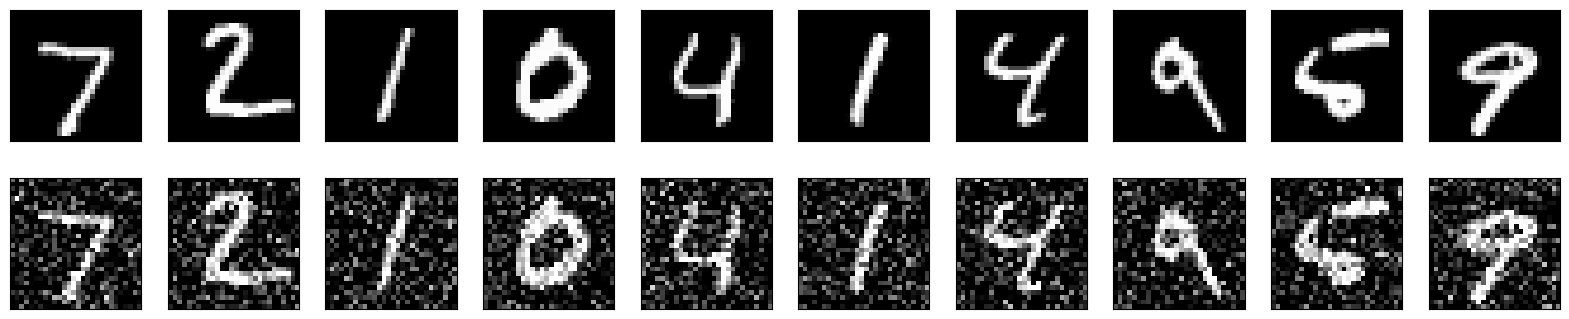

In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.optimizers import Adam

# Load the MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize the data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape the data to fit the model
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Introduce random noise to the test set to create anomalies
x_test_noisy = x_test + np.random.normal(loc=0.0, scale=0.3, size=x_test.shape)

# Clip the values to be between 0 and 1
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Plot some examples of normal and noisy images
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display normal images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


## Building the Autoencoder
An autoencoder consists of an encoder and a decoder. The encoder compresses the input into a latent-space representation, and the decoder reconstructs the input from this representation.

In this section, we will build a simple autoencoder using Keras. The encoder will reduce the 28x28 input images to a lower-dimensional representation, and the decoder will reconstruct the images from this representation.


In [4]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

In [ ]:
height, width, depth = 28, 28, 1
filters=(32, 64)
latentDim=16

chanDim = -1 # normalización por batch, en este caso el último numero, que son los canales por bacth de muestras

# define the input to the encoder
inputs = Input(shape=inputShape)
x = inputs
# loop over the number of filters
for f in filters:
    # apply a CONV => RELU => BN operation
    x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x) # igual que Relu pero admite ciertos valores negativos, que se controlan mediante la inclinación de la recta en la parte negativa, marcada por el alpha
    x = BatchNormalization(axis=chanDim)(x)
# flatten the network and then construct our latent vector
volumeSize = K.int_shape(x) # aquí almacenamos el shape de la capa de filtro 7,7,64
x = Flatten()(x)
latent = Dense(latentDim)(x)# esta densa es de 16, que sería el latentDim
# build the encoder model
encoder = Model(inputs, latent, name="encoder") # esta parte es el encoder

In [ ]:
latentInputs = Input(shape=(latentDim,))# aquí tenemos el latentDIm, pero importante incluir la "," para que coincida el shape
x = Dense(np.prod(volumeSize[1:]))(latentInputs)  # !!!!!!!!!!!!!!! el volumensize tiene en cuenta el batch, luego quitamos el 1er valor
x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x) # aqui tenemos el 7,7,64
# loop over our number of filters again, but this time in
# reverse order
for f in filters[::-1]:
	# apply a CONV_TRANSPOSE => RELU => BN operation
	x = Conv2DTranspose(f, (3, 3), strides=2,
		padding="same")(x)
	x = LeakyReLU(alpha=0.2)(x)
	x = BatchNormalization(axis=chanDim)(x)

# apply a single CONV_TRANSPOSE layer used to recover the
# original depth of the image
x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
outputs = Activation("sigmoid")(x)# esta activación tiene sentido al haber normalizado los datos de entrada, lo que nos dá valores entre 0 y 1, al igual qeu la salida de la sigmoide, que será entre 0 y 1.
# build the decoder model
decoder = Model(latentInputs, outputs, name="decoder")
# our autoencoder is the encoder + decoder

In [15]:
np.prod(volumeSize[1:])

784

In [17]:
# Define the dimensions of the input image
input_img = (28, 28, 1)
inputs = Input(shape=input_img)
latentDim=64
x = inputs
# Encoder
x = BatchNormalization(axis=-1)(x)
volumeSize = K.int_shape(x) # aquí almacenamos el shape de la capa de filtro 7,7,64
x = Flatten()(x)
x = Dense(128)(x)
latent = Dense(latentDim)(x)
encoder = Model(inputs, latent, name="encoder")
# Decoder
latentInputs = Input(shape=(latentDim,))
x = Dense(np.prod(volumeSize[1:]))(latentInputs)
x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
x = BatchNormalization(axis=-1)(x)
outputs = Activation("sigmoid")(x)
decoder = Model(latentInputs, outputs, name="decoder")
# # Autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)),
			name="autoencoder")
autoencoder.summary()
# Compile the model


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 64)             │       108,740 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 28, 1)      │        50,964 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,704 (623.84 KB)

 Trainable params: 159,700 (623.83 KB)

 Non-trainable params: 4 (16.00 B)

In [18]:
opt = Adam(learning_rate=0.0001)
autoencoder = Model(inputs, decoder(encoder(inputs)),
                    name="autoencoder")
autoencoder.compile(optimizer="adam", loss='mse')
# train the convolutional autoencoder
H = autoencoder.fit(
	inputs, inputs,
	validation_data=(inputs, inputs),
	epochs=5,
	batch_size=32)

# Display the model architecture
autoencoder.summary()

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 784)            │       101,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 218,192 (852.31 KB)

 Trainable params: 218,192 (852.31 KB)

 Non-trainable params: 0 (0.00 B)

## Training the Autoencoder
We will train the autoencoder using the normal images from the MNIST dataset. The goal is for the autoencoder to learn to reconstruct these normal images accurately.


In [19]:
# Train the autoencoder: epochs=10, batch_size=256, shuffle=True, validation_split=0.2


# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


NameError: name 'history' is not defined

## Evaluating the Autoencoder
Once the autoencoder is trained, we can evaluate its performance on the normal and noisy images. We expect the reconstruction error to be higher for the noisy (anomalous) images compared to the normal images.


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


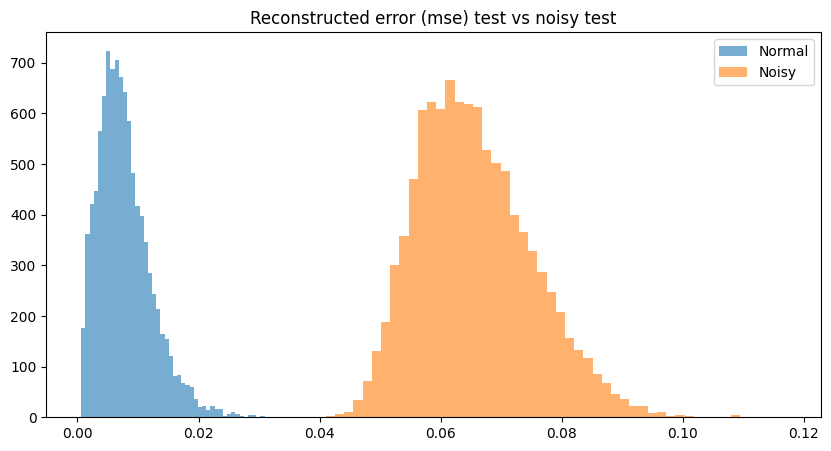

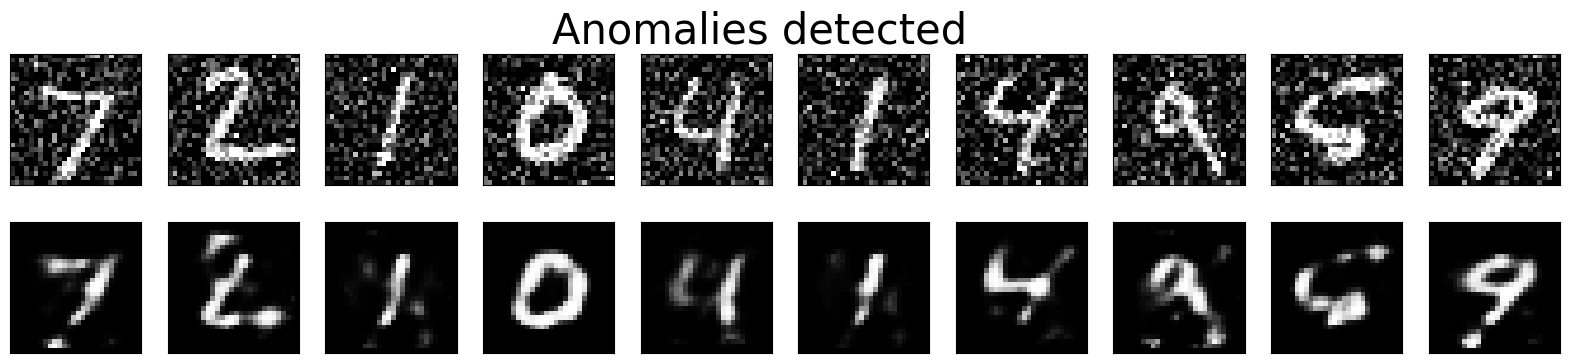

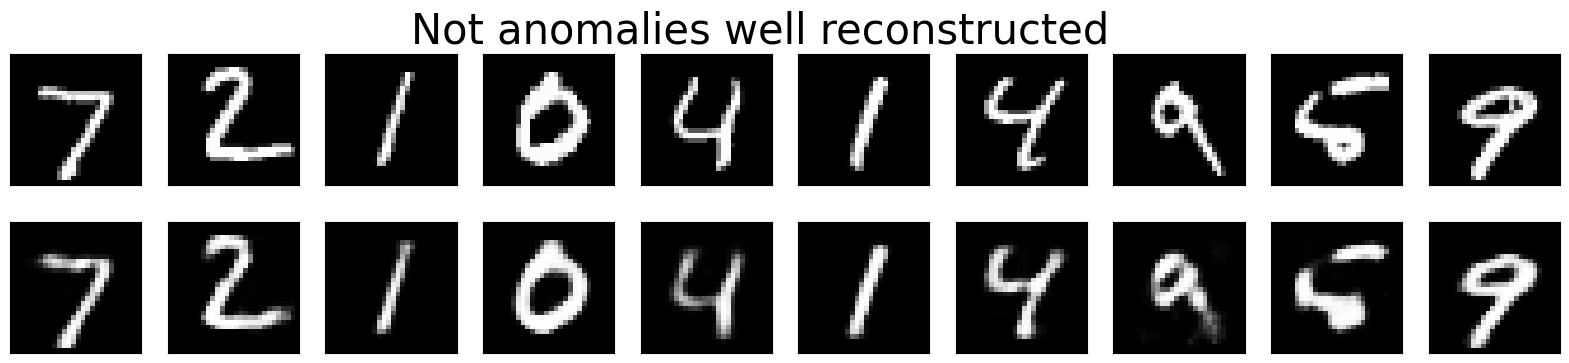

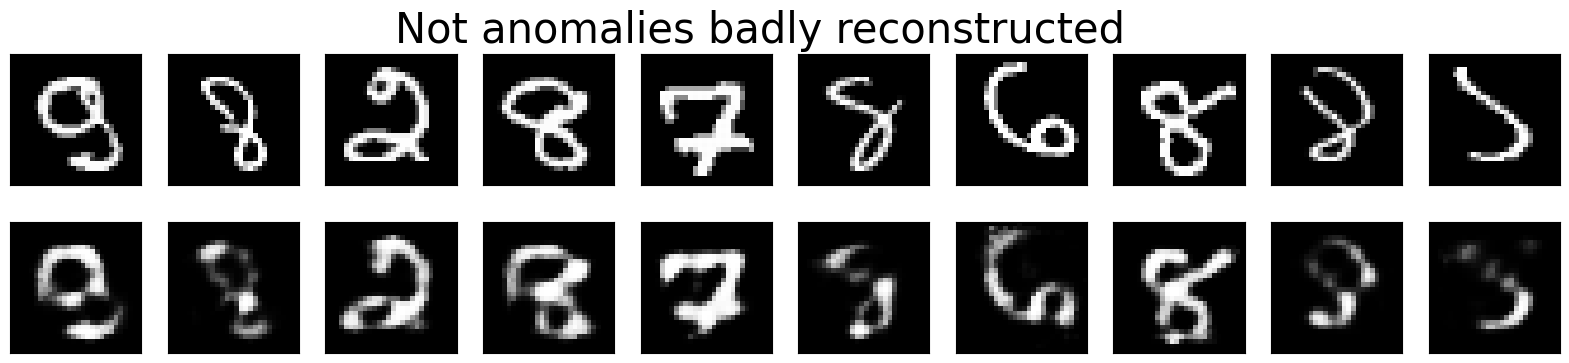

In [31]:
# Predict on the normal and noisy test sets
decoded_imgs = 
decoded_imgs_noisy = 

# Calculate the mean squared error between the original and reconstructed images
mse_normal = 
mse_noisy = 

# Plot the MSE for normal and noisy images
plt.figure(figsize=(10, 5))
plt.hist(mse_normal, bins=50, alpha=0.6, label='Normal')
plt.hist(mse_noisy, bins=50, alpha=0.6, label='Noisy')
plt.legend()
plt.title("Reconstructed error (mse) test vs noisy test")
plt.show()

# Define a threshold for anomaly detection
threshold = 0.025

# Detect anomalies
anomalies = mse_noisy > threshold

# Display some of the anomalies
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display noisy images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.suptitle("Anomalies detected", fontsize=30)
plt.show()

# Display some of the anomalies
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display noisy images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.suptitle("Not anomalies well reconstructed", fontsize=30)
plt.show()

errors = mse_normal > threshold

# Display some of the anomalies
n = 10
plt.figure(figsize=(20, 4))
for i in range(min(n, errors.sum())):
    # Display noisy images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[errors][i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[errors][i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.suptitle("Not anomalies badly reconstructed", fontsize=30)
plt.show()


# BONUS TRACK (pero chulo)
Repetir el experimento pero quitando una clase (el 7 o el 0 por ejemplo).
Entrenar el modelo sin esa clase y luego al predecir el text dejar las clases originales y la clase que falta para ver si esa clase la reconoceria como anomalia.

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.optimizers import Adam

In [ ]:
# Load the MNIST dataset
# YOUR CODE HERE

In [ ]:
# Normalize the data
# YOUR CODE HERE

In [ ]:
# Reshape the data to fit the model
# YOUR CODE HERE

In [ ]:
# Reshape the data to fit the model
# YOUR CODE HERE

In [ ]:
# Introduce random noise to the test set to create anomalies
# YOUR CODE HERE

In [ ]:
# Introduce random noise to the test set to create anomalies
# YOUR CODE HERE

In [ ]:
# Clip the values to be between 0 and 1
# YOUR CODE HERE

In [ ]:
# Plot some examples of normal and noisy images
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display normal images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Define the dimensions of the input image
input_img = Input(shape=(28, 28, 1))

In [ ]:
# Encoder
# YOUR CODE HERE

In [ ]:
# Decoder
# YOUR CODE HERE

In [ ]:
# Autoencoder model
autoencoder = Model(input_img, decoded)

In [ ]:
# Compile the model
# YOUR CODE HERE

In [ ]:
# Display the model architecture
autoencoder.summary()

In [ ]:
# Train the autoencoder
# YOUR CODE HERE

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Predict on the normal and noisy test sets
# YOUR CODE HERE

In [ ]:
# Calculate the mean squared error between the original and reconstructed images
# YOUR CODE HERE

In [ ]:
# Plot the MSE for normal and noisy images
plt.figure(figsize=(10, 5))
plt.hist(mse_normal, bins=50, alpha=0.6, label='Normal')
plt.hist(mse_noisy, bins=50, alpha=0.6, label='Noisy')
plt.legend()
plt.show()

In [ ]:
# Define a threshold for anomaly detection
threshold = 0.02

In [ ]:
# Detect anomalies
# YOUR CODE HERE

In [ ]:

# Display some of the anomalies
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display noisy images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
